In [1]:
# %matplotlib inline

import datacube
import xarray as xr
# import pandas as pd
# import numpy as np
# import geopandas as gpd
# import matplotlib.pyplot as plt
# from datacube.utils.cog import write_cog

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import mostcommon_crs
from dea_tools.plotting import display_map
# from dea_tools.bandindices import calculate_indices
# from dea_tools.spatial import subpixel_contours, interpolate_2d, contours_to_arrays
from dea_tools.coastal import tidal_tag
from dea_tools.dask import create_local_dask_cluster
from datacube.utils.geometry import GeoBox, Geometry
from shapely.geometry import box


# # Create local dask cluster to improve data load time
create_local_dask_cluster()

dc = datacube.Datacube(app='Intertidal_elevation')


/env/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46463 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:42065 Dashboard: /user/robbibt/proxy/46463/status,Cluster Workers: 1 Cores: 7 Memory: 63.57 GB


In [2]:
maxy, minx = -16.3089, 137.7789
miny, maxx = -16.5065, 137.9615
time_range = ('2017', '2021')
resolution = 10

geom = Geometry(geom=box(minx, miny, maxx, maxy),
                crs='EPSG:4326').to_crs('EPSG:3577')

display_map(x=(minx, maxx), y=(miny,maxy))


In [4]:
# Create the 'query' dictionary object
query_params = {
    'geopolygon': geom,
    'time': time_range}
    
load_params = {
    'measurements': ['fmask'],
    'group_by': 'solar_day',
    'resampling': {'*': 'average', 'fmask': 'nearest'},
    'dask_chunks': {'time': 1, 'x': 2048, 'y': 2048}
}

# Identify the most common projection system in the input query 
output_crs = mostcommon_crs(dc=dc, product='s2a_ard_granule', 
                            query=query_params)

In [10]:
s2_ds = dc.load(product=['s2a_ard_granule', 's2b_ard_granule'],
                output_crs=output_crs,
                resolution=(-resolution, resolution),
                **query_params,
                **load_params)
s2_ds['sensor'] = xr.DataArray(1, coords=[s2_ds.time])

ls_ds = dc.load(product=['ga_ls8c_ard_3'],
                time=query_params['time'],
                like=s2_ds.geobox,
                **load_params)   
ls_ds['sensor'] = xr.DataArray(2, coords=[ls_ds.time])

# Combine into a single ds
ds = xr.concat([s2_ds, ls_ds], dim='time').sortby('time')
# ds.load()


In [35]:
ls_ds

<xarray.Dataset>
Dimensions:      (time: 135, y: 2217, x: 1984)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-05T00:53:17.590198 ... 2021-12...
  * y            (y) float64 8.195e+06 8.195e+06 ... 8.173e+06 8.173e+06
  * x            (x) float64 7.967e+05 7.967e+05 ... 8.165e+05 8.165e+05
    spatial_ref  int32 32753
Data variables:
    fmask        (time, y, x) uint8 dask.array<chunksize=(1, 2048, 1984), meta=np.ndarray>
    sensor       (time) int64 2 2 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2 2 2
Attributes:
    crs:           PROJCS["WGS 84 / UTM zone 53S",GEOGCS["WGS 84",DATUM["WGS_...
    grid_mapping:  spatial_ref

In [24]:
ds.isel(time=19)

<xarray.Dataset>
Dimensions:      (y: 2217, x: 1984)
Coordinates:
    time         datetime64[ns] 2017-06-07T00:46:33.783345
  * y            (y) float64 8.195e+06 8.195e+06 ... 8.173e+06 8.173e+06
  * x            (x) float64 7.967e+05 7.967e+05 ... 8.165e+05 8.165e+05
    spatial_ref  int32 32753
Data variables:
    fmask        (y, x) uint8 dask.array<chunksize=(2048, 1984), meta=np.ndarray>
    sensor       int64 2
    clear        float64 nan
    tide_height  float64 0.409
Attributes:
    crs:           epsg:32753
    grid_mapping:  spatial_ref

In [11]:
# Fmask stats
cloudy = ((ds.fmask == 2) | (ds.fmask == 3))  #.sum(dim=['x', 'y'])
# clear = ((ds.fmask == 1) | (ds.fmask == 4) | (ds.fmask == 5))  #.sum(dim=['x', 'y'])

# # Compute cloudy percentage
# ds['clear'] = (clear /
#               (clear.sum(dim=['x', 'y']) + cloudy.sum(dim=['x', 'y'])))

In [134]:
ds['Clear pixels'] = 1.0 - cloudy.where(ds.fmask != 0).mean(dim=['x', 'y']).compute()

/env/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
distributed.utils_perf - WARNING - full garbage collections took 61% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 62% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 63% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 63% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 63% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 63% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 63% CPU time recently (threshold: 10%)


In [164]:
# Calculate tides for each timestep in the satellite dataset
ds = tidal_tag(ds=ds, tidepost_lat=None, tidepost_lon=None)

Setting tide modelling location from dataset centroid: 137.87, -16.41


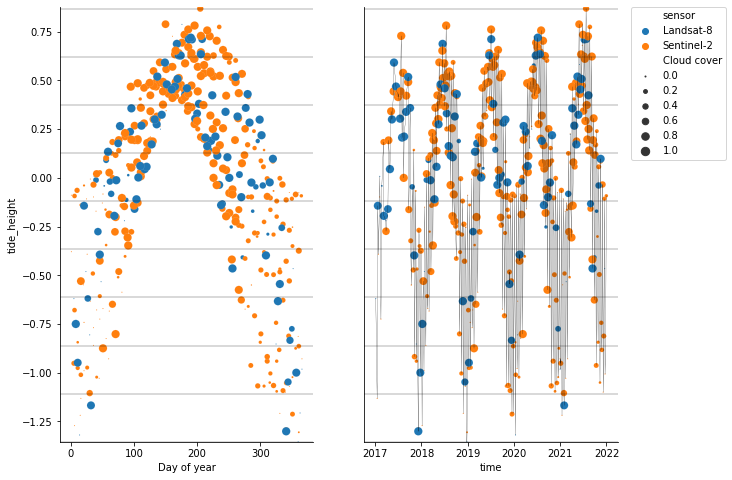

In [191]:
import seaborn as sns

df = ds[['tide_height', 'sensor', 'Cloud cover']].to_dataframe().dropna()
df['Month'] = df.index.month
df['Day of year'] = df.index.day_of_year
df['sensor'] = df.sensor.replace({1: 'Sentinel-2', 2: 'Landsat-8'})

# classes
n = 10

# Bin tide heights into 9 tidal intervals from low (1) to high tide (9)
import numpy as np
binInterval = np.linspace(df.tide_height.min(),
                          df.tide_height.max(),
                          num=n)

# import matplotlib.pyplot as plt
# fig, axes = plt.subplots(1, 1, figsize=(8, 5))
# df.plot.scatter(x='Day of year', y='tide_height', alpha=df.clear, ax=axes)
# for i in binInterval: plt.axhline(i, c='black', alpha=0.5)
# plt.ylim(df.tide_height.min(), df.tide_height.max())

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 8))
sns.scatterplot(data=df.sort_values('Cloud cover'), x='Day of year', y='tide_height', hue='sensor', size='Cloud cover', sizes=(1, 70), ax=ax, legend=False)
ax.set_ylim(df.tide_height.min(), df.tide_height.max()*1.01)

sns.lineplot(data=df.sort_values('Cloud cover').reset_index(), x='time', y='tide_height', ax=ax2, color='black', linewidth=0.2)
sns.scatterplot(data=df.sort_values('Cloud cover').reset_index(), x='time', y='tide_height', hue='sensor', size='Cloud cover', sizes=(1, 70), ax=ax2)

ax2.set_ylim(df.tide_height.min(), df.tide_height.max()*1.01)
ax2.get_yaxis().set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 
# Put the legend out of the figure
ax2.legend(bbox_to_anchor=(1.05, 1), 
           loc=2, 
           borderaxespad=0.,
          )

for i in binInterval: ax.axhline(i, c='black', alpha=0.2), ax2.axhline(i, c='black', alpha=0.2), 

# fig.savefig('tidal_plot_time.png', bbox_inches='tight', facecolor='white', transparent=False)

fig.savefig('tidal_plot_doy.png', bbox_inches='tight', facecolor='white', transparent=False)

In [43]:
site = 'IDO71015'

import pandas as pd
df = pd.concat([pd.read_csv(f'data/{site}_{year}.csv', 
                            index_col=0,
                            parse_dates=True, 
                            na_values=-9999)
                for year in range(2017, 2021)])

df.index.name = 'time'

<AxesSubplot:xlabel='time'>

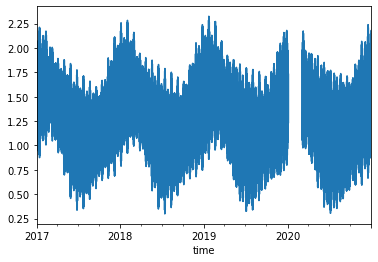

In [48]:
(df['Sea Level'] - df['Residuals']).plot()